# GridPlots
Like subplots but more flexible: can have subfigures of different sizes (irregular subplots). 
Matplotlib: https://matplotlib.org/api/_as_gen/matplotlib.gridspec.GridSpec.html#matplotlib.gridspec.GridSpec
Plotly: https://plot.ly/python/user-guide/#looking-at-examples




In [1]:
from plotly import __version__
from plotly.offline import init_notebook_mode, plot, iplot
from plotly import tools
from plotly.graph_objs import Scatter, Layout

from collections import namedtuple 

__version__ # requires version >= 1.9.0
init_notebook_mode(connected=True)


In [2]:
iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get some data

In [4]:
df = sns.load_dataset('iris')
df.sample(10)

sepal_length  sepal_width  petal_length  petal_width     species
112           6.8          3.0           5.5          2.1   virginica
101           5.8          2.7           5.1          1.9   virginica
77            6.7          3.0           5.0          1.7  versicolor
42            4.4          3.2           1.3          0.2      setosa
107           7.3          2.9           6.3          1.8   virginica
18            5.7          3.8           1.7          0.3      setosa
124           6.7          3.3           5.7          2.1   virginica
32            5.2          4.1           1.5          0.1      setosa
41            4.5          2.3           1.3          0.3      setosa
137           6.4          3.1           5.5          1.8   virginica

# Plotting with Matplotlib

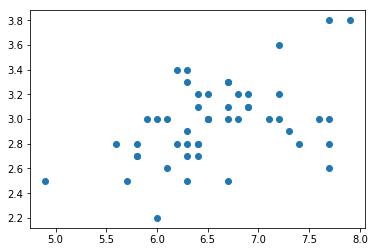

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
ax.plot('sepal_length', 'sepal_width', 'o', data=df[df.species == 'virginica']);


Making the plot interactive with Plotly

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import warnings

In [7]:
def to_plotly(ax=None, fig=None):
    if fig is None:
        fig = ax.get_figure()
    pf = tools.mpl_to_plotly( fig )
    return iplot(pf)

to_plotly(ax)
#py.offline.iplot_mpl(ax.get_figure())

## Seaborn

In [8]:
fg = sns.factorplot(x='sepal_width',y='sepal_length', hue='species', data=df, width=12, aspect=2.5);
to_plotly(fg.ax)

In [9]:
xarr = np.linspace(0, 2*np.pi*10, 1000)
yarr = xarr * np.sin(xarr)

iplot({
    "data": [Scatter(x=xarr, y=yarr)],
    "layout": Layout(title="hello world")
})

# GridSpec and GridSpecFromSubplotSpec

This will allow us to plot arbitrarily complex functions provided we expect a gridspec!

For example, let's say we want to plot the data, it's Fourier transform amplitude and its Fourier transform phase.

In [10]:
import matplotlib.gridspec as gridspec

In [11]:
x = np.linspace(0, 50, 5000, endpoint=False)

In [12]:
def get_data(f1, f2, f3):
    y = np.sin(2 * np.pi * f1 * x) + np.sin(2 * np.pi * f2 * x) + np.sin(2 * np.pi * f3 * x)
    Y = np.fft.rfft(y)
    return y, abs(Y), np.unwrap(np.angle(Y))

y1, Y1, Phi1 = get_data(1, 2, 3)
y2, Y2, Phi2 = get_data(4, 5, 7)

In [13]:
freq = np.fft.rfftfreq(len(x), d=x[1] - x[0])

# The traditional way: one at a time

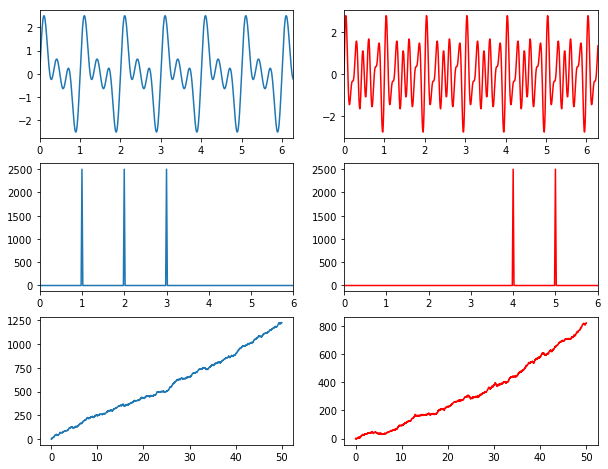

In [14]:
fig, axes = plt.subplots(3,2, figsize=(10, 8))
axes[0,0].plot(x, y1)
axes[0,0].set_xlim([0, 2 * np.pi])
axes[1,0].plot(freq, Y1)
axes[1,0].set_xlim([0, 6])
axes[2,0].plot(freq, Phi1)

axes[0,1].plot(x, y2, 'r')
axes[0,1].set_xlim([0, 2 * np.pi])
axes[1,1].plot(freq, Y2, 'r')
axes[1,1].set_xlim([0, 6])
axes[2,1].plot(freq, Phi2, 'r')

# The cool way: GridSpec!

In [15]:
def apply(y):
    Y = np.fft(Y)
    return np.abs(Y), np.unwrap(np.angle(Y))

def cool_plot(y1, gs = None, *args, **kwargs):
    Y1 = np.fft.rfft(y1)
    amplitude = Y1 = np.abs(Y1)
    phase = np.unwrap(np.angle(Y1))
    if gs is None:
        gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[0, 0:2])
    ax1.plot(x, y1, *args, **kwargs)
    ax1.set_xlim([0, 2*np.pi])

    ax2 = plt.subplot(gs[1, 0])
    ax2.plot(freq, Y1, *args, **kwargs)
    ax2.set_xlim([0,6])

    ax3 = plt.subplot(gs[1, 1])
    ax3.plot(freq, Phi1, *args, **kwargs)
    
    plt.tight_layout()
    
def cool_plots(ylst, gs, *args, **kwargs):
    for i, y1 in enumerate(ylst):
        gsi = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[i])
        cool_plot(y1, gsi)
        

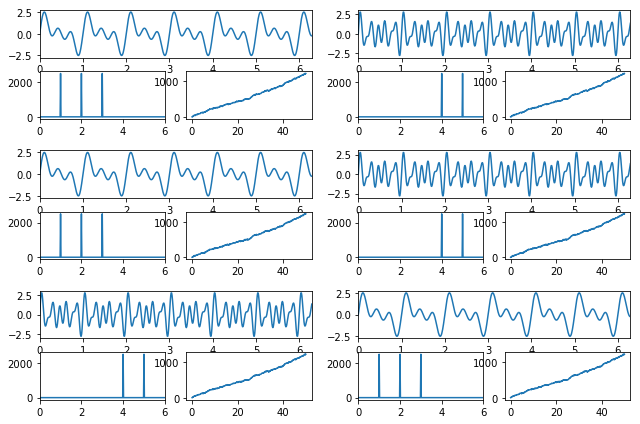

In [16]:
fig = plt.figure(1, figsize=(9, 6))
gs0 = gridspec.GridSpec(3, 2)
#i, Y1, gslst = 
cool_plots([y1, y2, y1, y2, y2, y1], gs0)
#to_plotly(fig)

Use a similar design/API to Plotly's, replacing traces by callbacks. 

In [17]:
Trace = namedtuple('Trace', ['plot_func', 'args', 'kwargs'])

def mbuild_traces(y1):
    Y1 = np.fft.rfft(y1)
    amplitude = Y1 = np.abs(Y1)
    phase = np.unwrap(np.angle(Y1))

    def f1(x1, y1, ax=None):
        if ax is None:
            ax = plt.gca()
        ax.plot(x, y1)
        ax.set_xlim([0, 2*np.pi])
    
    trace1 = Trace(f1, [x, y1], {})
    
    def f2(freq, Y1, ax=None):
        if ax is None:
            ax = plt.gca()
        ax.plot(freq, Y1)
        ax.set_xlim([0,6])
        
    trace2 = Trace(f2, [freq, Y1], {})

    def f3(freq, Phi1, ax=None):
        if ax is None:
            ax = plt.gca()
            
        ax.plot(freq, Phi1)
    
    trace3 = Trace(f3, [freq, Phi1], {})
    return [trace1, trace2, trace3]

def spec_to_axis(gs, spec, i, j):
    if spec is None:
        return None
    else:
        height = spec.get('rowspan', 1)
        width = spec.get('colspan', 1)
        ax = plt.subplot(gs[i:i+height, j:j+width])
        return ax
    
def mplot_traces(traces, gs, sub_spec):
    k = 0
    for i, row in enumerate(sub_spec):
        for j, spec in enumerate(row):
            ax = spec_to_axis(gs, spec, i, j)
            if ax:
                tr = traces[k]
                tr.plot_func(*tr.args, ax=ax, **tr.kwargs)
                k += 1

def mgridplot(traces_func, y, grid_spec, subplot_spec=None):
    n = len(grid_spec)
    m = len(grid_spec[0])
    if subplot_spec is None:
        gs = gridspec.GridSpec(n, m)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(m, n, subplot_spec=subplot_spec)    
    traces = traces_func(y)
    fig = mplot_traces(traces, gs, grid_spec)
    return fig  



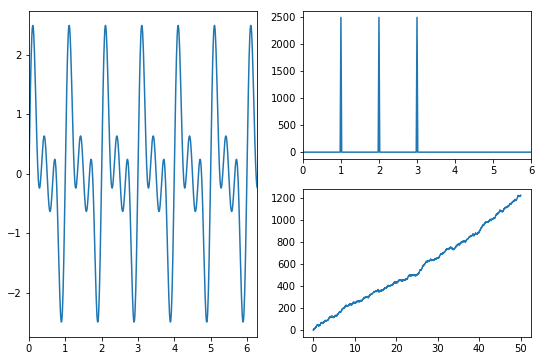

In [18]:
fig = plt.figure(1, figsize=(9, 6))
msub_spec1 = [[{'rowspan': 1, 'colspan': 2}, None], 
              [{},                             {}]]
msub_spec2 = [[{'rowspan': 2, 'colspan': 1}, {}], 
              [None,                         {}]]
mgridplot(mbuild_traces, y1, msub_spec2)


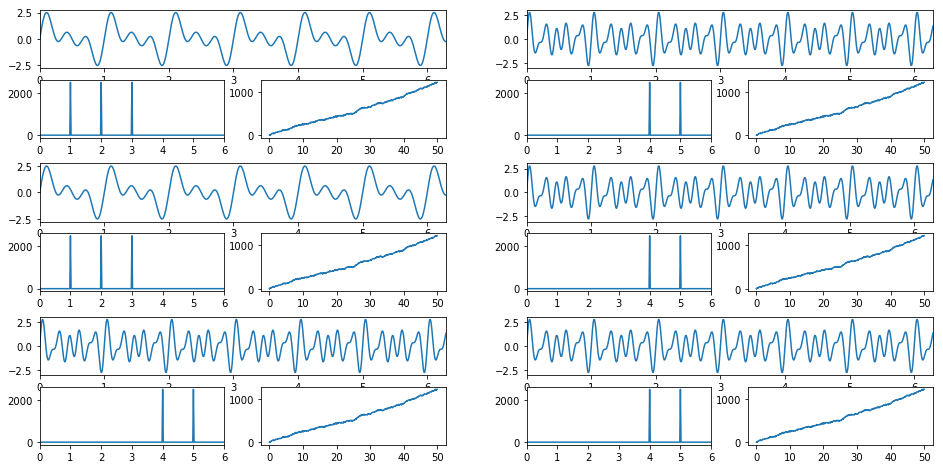

In [19]:
def mgridplots(traces_func, ylst, grid_spec, nbrows, nbcols):
    M = nbrows
    N = nbcols
    n = len(grid_spec)
    m = len(grid_spec[0])
    gs = gridspec.GridSpec(M, N)
    for subplot_spec, y in zip(gs, ylst):
        mgridplot(traces_func, y, grid_spec, subplot_spec)

plt.figure(figsize=(16, 8))    
mgridplots(mbuild_traces, [y1, y2, y1, y2, y2, y2], msub_spec1, 3, 2)

# The awesome way: plotly

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go



In [21]:
# Use a subspec instead and loop over it??
def append_traces_to_subfig(subfig, traces):
    """Given a figure, a sub figure specification, and a flat list of traces
    append each trace to the figure in the appropriate location. 
    """
    fig = subfig.parent_fig
    i = subfig.row_position
    j = subfig.col_position
    sub_spec = subfig.grid_spec
    
    k = 0
    for ioffset, row_spec in enumerate(sub_spec):
        for joffset, spec in enumerate(row_spec):
            if spec is not None:
                fig.append_trace(traces[k], i + ioffset, j + joffset)
                k += 1
                if k >= len(traces):
                    return fig
    return fig

SubFig = namedtuple('SubFig', ['parent_fig', 'grid_spec', 'row_position', 'col_position'])

def gridplot(traces_func, y, grid_spec):
    """Create a grid plot by applying ``traces_func`` to ``y`` to generate a list of traces, and laying 
    them out according to ``grid_spec``. 
    """
    n = len(grid_spec)
    m = len(grid_spec[0])
    fig = tools.make_subplots(rows=n, cols=m, specs=grid_spec)
    subfig = SubFig(fig, grid_spec, 1, 1)
    traces = traces_func(y)
    fig = append_traces_to_subfig(subfig, traces)
    iplot(fig)
    return fig
    
    


In [22]:
def build_traces(y1):
    Y1 = np.fft.rfft(y1)
    amplitude = Y1 = np.abs(Y1)
    phase = np.unwrap(np.angle(Y1))
        
    trace1 = go.Scatter(x=x, y=y1)
    trace2 = go.Scatter(x=freq, y=Y1)
    trace3 = go.Scatter(x=freq, y=phase)
    return [trace1, trace2, trace3]

grid_spec1 = [[{'rowspan': 1, 'colspan': 2}, None], 
             [{},                         {}]]  # for each subfig
grid_spec2 = [[{'rowspan': 2, 'colspan': 1}, {}], 
              [None,                         {}]]  # for each subfig

gridplot(build_traces, y1, grid_spec1);

This is the format of your plot grid:
[ (1,1) x1,y1           -      ]
[ (2,1) x2,y2 ]  [ (2,2) x3,y3 ]



In [23]:
def gridplots(func, ylst, grid_spec, nbrows, nbcols):
    """Create ``nbrows`` by ``nbcols`` specplots, each of which is produced by mapping ``func`` to ``ylst`` 
    to generate a list of traces that are layed out according to ``grid_spec``.
    
    Parameters
    ----------
    
    """
    if len(ylst) > nbrows * nbcols:
        raise ValueError(
            'Not enough subplots to map all values (len(ylst) = {}): increase the number of rows or columns.'
            .format(len(ylst)))
    N = nbrows
    M = nbcols
    n = len(grid_spec)
    m = len(grid_spec[0])
    specs = np.tile(grid_spec, (N, M)).tolist()                         
    fig = tools.make_subplots(rows=N * n, cols=M * m,
                              specs=specs)
    for k, y in enumerate(ylst):
        # c-order with i and j the row and column indices of the 
        # start of each subfigure block 
        i = k // M
        j = k % M
        traces = func(y)
        subfig = SubFig(fig, grid_spec, n * i + 1, n * j + 1)
        append_traces_to_subfig(subfig, traces)
    iplot(fig)    
    return fig

In [24]:
N, M = 3, 2
sub_spec = [[{'rowspan': 1, 'colspan': 2}, None], 
            [{},                         {}]]  # for each subfig

fig = gridplots(build_traces, [y1, y2, y1, y2, y2, y2], sub_spec, 3, 2);

This is the format of your plot grid:
[ (1,1) x1,y1             -        ]  [ (1,3) x2,y2             -        ]
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]    [ (2,3) x5,y5 ]    [ (2,4) x6,y6 ]  
[ (3,1) x7,y7             -        ]  [ (3,3) x8,y8             -        ]
[ (4,1) x9,y9 ]    [ (4,2) x10,y10 ]  [ (4,3) x11,y11 ]  [ (4,4) x12,y12 ]
[ (5,1) x13,y13           -        ]  [ (5,3) x14,y14           -        ]
[ (6,1) x15,y15 ]  [ (6,2) x16,y16 ]  [ (6,3) x17,y17 ]  [ (6,4) x18,y18 ]



# Going from Plotly to Matplotlib
 - in matplotlib, the equivalent of a trace would be a function that takes an axis object and 
   plots it in the right location (so we'd want a list of function instead of a list of traces)
 - given a SpecGrid and some callback functions (traces), 
   we can generate a GridSpecfromSubplotSpec and plot each traces in the appropriate location. 
   can we have a similar API to that of plotly, i.e. use a grid_spec and convert it to Matplotlib's API internally?

# References

## Other datasets

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    datasets = sns.get_dataset_names()
    
datasets

['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'iris',
 'planets',
 'tips',
 'titanic']